# Exploring lasso regression with Relative-continuity 

In [38]:
import numpy as np
from sklearn.datasets import load_boston
from numpy import linalg as LA

## Importing datasets

In [39]:
boston = load_boston()
X = boston.data
y = boston.target
y = y.reshape((y.shape[0],1))

In [40]:
print(X.shape)
print(y.shape)

(506, 13)
(506, 1)


## Evaluate f

In [41]:
# this function evaluates the LASSO objective function at w for a given regulatizer lamb
# inputs:
#     _ X,y (feature matrix and label vector)
#     _ w (point to evaluate at)
#     _ lamb (regularizer)
def f(w,X,y,lamb):
    N = X.shape[0]
    val = (1/N)*(LA.norm(np.matmul(X,w)-y)**2) + lamb*LA.norm(w,ord = 1)

    return val

In [42]:
# small test
w = 0.02*np.ones((X.shape[1],1))
f(w,X,y,1)

140.08485760541683

## Subgradient of f

In [43]:
# this function returns a subgradient of the LASSO objective function at w for a given regulatizer lamb
# inputs:
#     _ X,y (feature matrix and label vector)
#     _ w (point to evaluate at)
#     _ lamb (regularizer)
def g(w,X,y,lamb):
    # a subgradient of the mse
    N = X.shape[0]
    Df = (2/N)*(np.matmul(np.matmul(X.T,X),w) - np.matmul(X.T,y))
    # a subgradient of the regularization part
    q = np.zeros(w.shape)
    q[w >= 0] = 1
    q[w < 0] = -1

    return Df + lamb*q

In [44]:
# small test
w = np.zeros((X.shape[1],1))
g(w,X,y,1)

array([[ -1.00063651e+02],
       [ -6.65433992e+02],
       [ -4.39964743e+02],
       [ -2.93438735e+00],
       [ -2.30886479e+01],
       [ -2.91190030e+02],
       [ -2.89457763e+03],
       [ -1.79687250e+02],
       [ -3.68348221e+02],
       [ -1.69468166e+04],
       [ -8.10528577e+02],
       [ -1.66316067e+04],
       [ -4.72514462e+02]])

## Second step of mirror descent (optimization)

### Computing alpha, beta, gamma

In [45]:
# this function computes the bound parameters alpha, beta, gamma
# inputs:
#     _ X,y (feature matrix and label vector)
#     _ lamb (regularizer)
def compute_bound_params(X,y,lamb):
    N = X.shape[0]
    # Computing the relevant quantities
    _, sigmas, _ = LA.svd(np.matmul(X.T,X)) # Eig of X.T@X
    r = LA.norm(np.matmul(X.T,y)) # Norm of X.T@Y
    # Defining sigma,ro,gamma
    alpha = (4/(N**2))*(sigmas[0]**2)
    beta = (8/(N**2))*sigmas[0]*r + (4/np.sqrt(N))*sigmas[0]*lamb
    gamma = ( (4*r/N) + lamb*np.sqrt(N) )**2
    
    return alpha,beta,gamma

In [46]:
# small test
alpha,beta,gamma = compute_bound_params(X,y,1)
print(alpha,beta,gamma)

391919099163.0 30026728033.7 2298328675.71


### solving the 2nd step

In [47]:
# this function computes the inner arg-min
# inputs:
#     _ X,y (feature matrix and label vector)
#     _ w_i (point to evaluate at)
#     _ lamb (regularizer)
#     _ ro,sig,gamma (bound params)
#     _ step (step size to take)
def find_w_new(w_i,X,y,lamb,alpha,beta,gamma,ti):
    Dhi = (alpha*LA.norm(w_i)**2 + beta*LA.norm(w_i) + gamma)*w_i
    gi = g(w_i,X,y,lamb)
    k = ti*gi - Dhi
    a = alpha*(LA.norm(k)**2)
    b = beta*LA.norm(k)
    c = gamma
    d = -1
    # here we find a root of the cubic polynomial
    p = [a,b,c,d]
    roots = np.roots(p)
    roots = roots[~np.iscomplex(roots)]
    roots = np.real(roots)
    theta_star = np.max(roots)

    w_ip1 = -theta_star*k
    
    return w_ip1

In [48]:
# small test
w = np.zeros((X.shape[1],1))
find_w_new(w,X,y,1,alpha,beta,gamma,1e-5)

array([[  4.35375722e-13],
       [  2.89529517e-12],
       [  1.91428122e-12],
       [  1.27674835e-14],
       [  1.00458425e-13],
       [  1.26696426e-12],
       [  1.25942719e-11],
       [  7.81817028e-13],
       [  1.60267861e-12],
       [  7.37353920e-11],
       [  3.52659994e-12],
       [  7.23639177e-11],
       [  2.05590465e-12]])

### Running the algorithm

In [49]:
# this function performs mirror descent with provided parameters
# inputs:
#     _ lambda (regularization parameter)
#     _ n_iter (number of iterations for which to run the descent algorithm)
#     _ t (step size)
# outputs:
#     _ fs (history of function evaluations)
#     _ wis (history of weights)
def mirror_descent(lamb, n_iter, t):
    w_i = np.zeros((X.shape[1],1)) # initial point
    fs = []
    wis = []
    for i in range(n_iter):
        w_i = find_w_new(w_i,X,y,lamb,alpha,beta,gamma,t)
        if(i>0):
            fs.append(min(f(w_i,X,y,lamb),fs[-1]))
        else:
            fs.append(f(w_i,X,y,lamb))   
        wis.append(w_i)
    return fs, wis

In [50]:
# here we run our mirror descent algorithm
lamb = 100
alpha,beta,gamma = compute_bound_params(X,y,lamb)
n_iter = 1000
t = 6000
fs, wis = mirror_descent(lamb,n_iter,t)

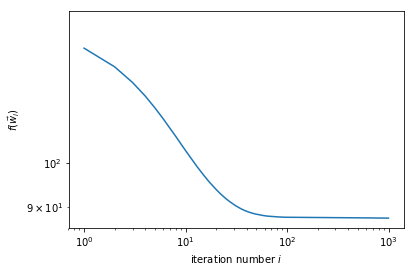

In [51]:
from matplotlib import pyplot as plt
plt.loglog(fs)
plt.xlabel('iteration number ' + r'$i$')
plt.ylabel(r'$f(\vec w_i)$')
plt.show()

In [52]:
wis = np.array(wis)
print(wis[:,0])

[[  1.54786212e-06]
 [ -2.27389377e-04]
 [ -1.78585394e-04]
 [ -1.31549822e-04]
 [ -8.29223904e-05]
 [ -3.18408346e-05]
 [  2.16809175e-05]
 [ -1.84119653e-04]
 [ -1.23738129e-04]
 [ -6.18922690e-05]
 [  1.17298450e-06]
 [ -1.85766121e-04]
 [ -1.18438804e-04]
 [ -5.05260791e-05]
 [  1.78320360e-05]
 [ -1.55622953e-04]
 [ -8.44930752e-05]
 [ -1.31907943e-05]
 [  5.83372815e-05]
 [ -1.05186931e-04]
 [ -3.17873361e-05]
 [  4.17529243e-05]
 [ -1.15523069e-04]
 [ -4.05321031e-05]
 [  3.44236874e-05]
 [ -1.17694280e-04]
 [ -4.15287433e-05]
 [  3.45912658e-05]
 [ -1.13254696e-04]
 [ -3.61834071e-05]
 [  4.07819753e-05]
 [ -1.03343017e-04]
 [ -2.55722190e-05]
 [  5.20753308e-05]
 [ -8.88751756e-05]
 [ -1.05513893e-05]
 [  6.76404765e-05]
 [ -7.06039310e-05]
 [  7.98719624e-06]
 [ -1.28537017e-04]
 [ -4.94361941e-05]
 [  2.96649416e-05]
 [ -1.04912948e-04]
 [ -2.54339961e-05]
 [  5.40592299e-05]
 [ -7.86464800e-05]
 [  1.14353902e-06]
 [ -1.30331829e-04]
 [ -5.01917199e-05]
 [  2.97223267e-05]


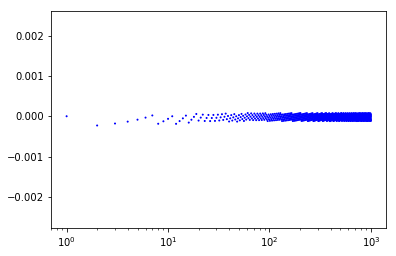

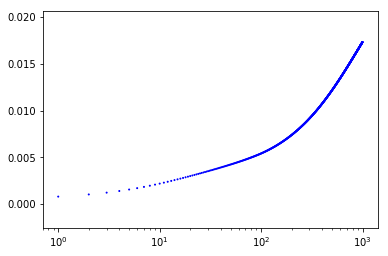

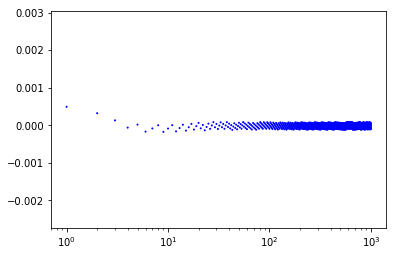

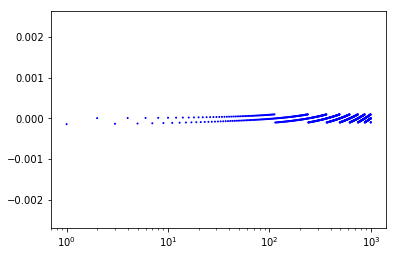

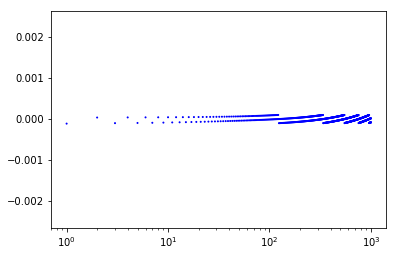

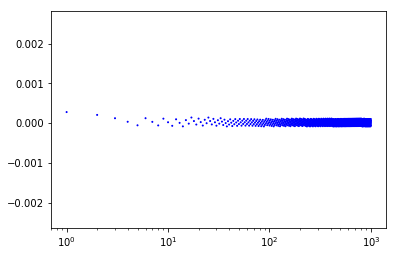

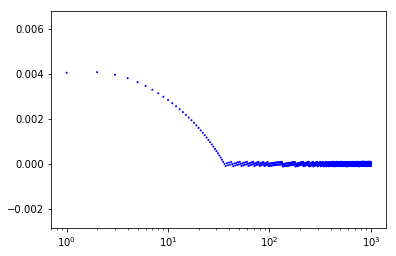

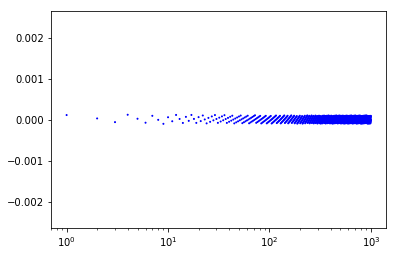

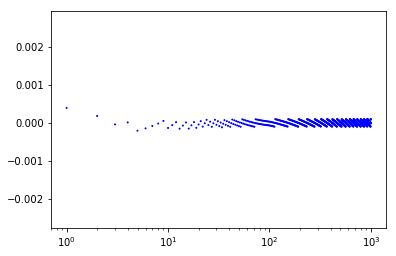

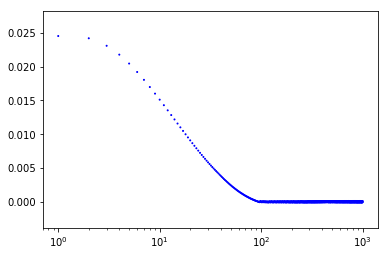

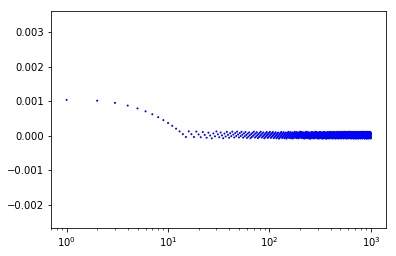

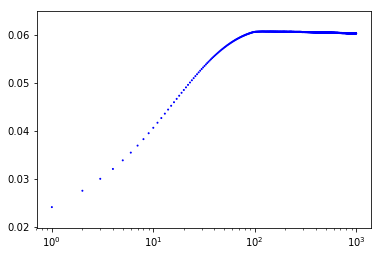

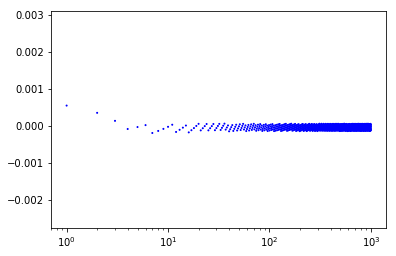

In [53]:
itr = [i for i in range(1,1001)]
s = [1 for i in range(1000)]
for i in range(13):
    ax = plt.gca()
    ax.scatter(itr,wis[:,i],s=s, color='blue')
    ax.set_xscale('log')
    plt.show()

### Other tests

In [17]:
# here we run our mirror descent algorithm
lambs = [0.01,0.1,0,1,10,100]
fss = []
for lamb in lambs:
    alpha,beta,gamma = compute_bound_params(X,y,lamb)
    n_iter = 1000
    t = 6000
    fs, wis = mirror_descent(lamb,n_iter,t)
        
    fss.append(fs)

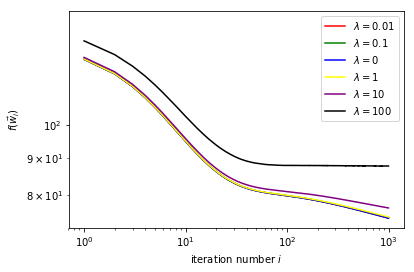

In [18]:
cols = ['red','green','blue','yellow','purple','black']
for i in range(len(lambs)):
    lab = r'$\lambda = $' + str(lambs[i])
    plt.loglog(fss[i], color=cols[i], label=lab)
plt.legend()
plt.xlabel('iteration number ' + r'$i$')
plt.ylabel(r'$f(\vec w_i)$')
plt.show()

# ISTA

In [19]:
boston = load_boston()
X = boston.data
y = boston.target

## Model

In [20]:
class ISTA:
    
    def __init__(self,lamda):
        
        self.lamda = lamda
        
        
    def evaluate_f(self,X,y,w):
        
        return (1/X.shape[0]*LA.norm(y-X@w)**2 + self.lamda*LA.norm(w,ord=1))
    
    def gradf(self,X,y,w):
        
        return (1/X.shape[0]*(2*X.T@X@w - 2*X.T@y))
    
    def solve_subproblem(self,X,y,w_k,L):
        '''
        L is the the smoothness coefficient of f
        '''
        c = w_k - 1/L*self.gradf(X,y,w_k)
        l = self.lamda/L
        w_next =np.sign(c)*np.maximum(c-l*np.ones(c.shape[0]),0)
        return (w_next)
    
        
    def evaluate_L(self,X):
        _,sigmas,_ = LA.svd(X.T@X)
        return(2/X.shape[0]*(sigmas[0]))
        
    def fit(self,X,y,w_init = np.zeros(X.shape[1]),num_iter = 1000):
        '''
        Fitting the data(solving the optim)
        '''
        L = self.evaluate_L(X)
        weights = []
        function_value = []
        w = w_init
        weights.append(w)
        function_value.append(self.evaluate_f(X,y,w))
        
        for i in range(num_iter):
            
            w = self.solve_subproblem(X,y,w,L)
            weights.append(w)
            function_value.append(self.evaluate_f(X,y,w))
            
        self.w = weights[-1]
        self.wis = np.array(weights)

        return (weights,function_value)
    
    def predict(self,X_new):
        
        return (X_new@self.w)
            
            
        

## Test

In [21]:
# We expect to see a sparse output
ista = ISTA(lamda = 100)
weights,function_value = ista.fit(X,y)
ista.w 

array([-0.        ,  0.02109664, -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.06030191, -0.        ])

In [22]:
preds = ista.predict(X)
y.shape[0] == preds.shape[0]

True

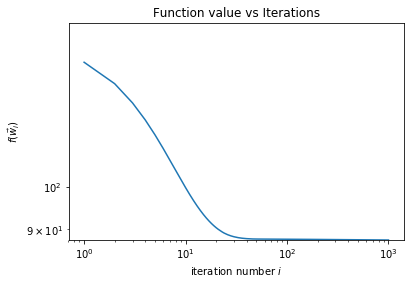

In [23]:
iterations = np.arange(len(function_value))
plt.loglog(function_value)
plt.xlabel('iteration number ' + r'$i$')
plt.ylabel(r'$f(\vec w_i)$')
plt.ylim((0,150))
plt.title('Function value vs Iterations')
plt.show()

In [24]:
print(ista.wis[:,1].shape)

(1001,)


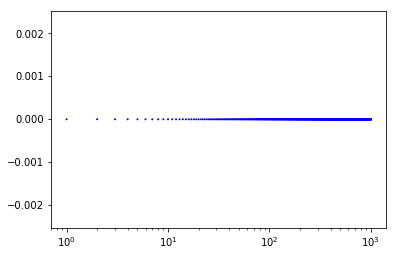

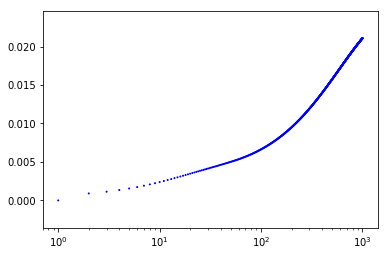

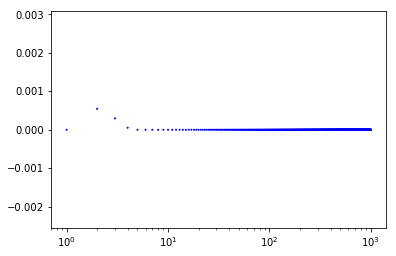

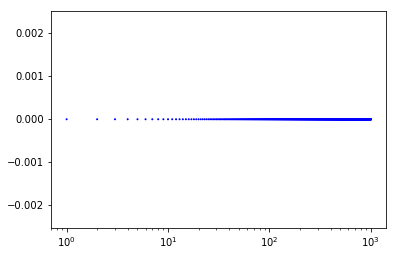

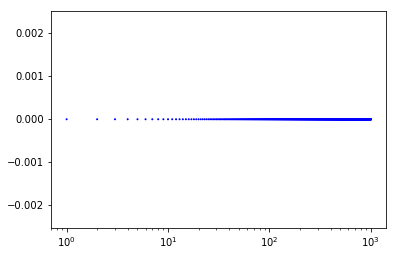

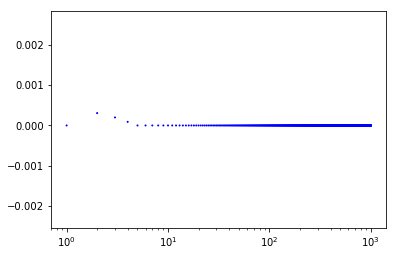

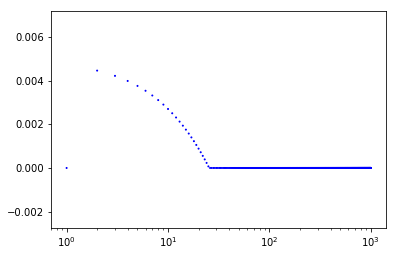

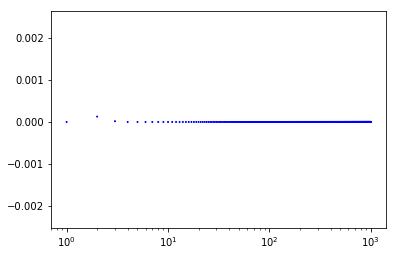

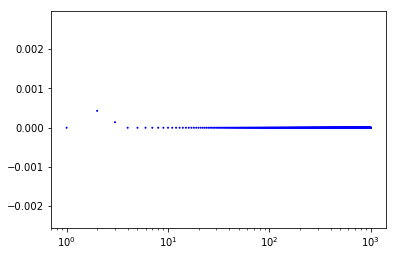

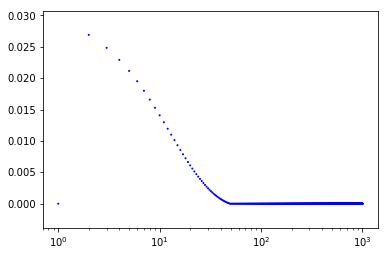

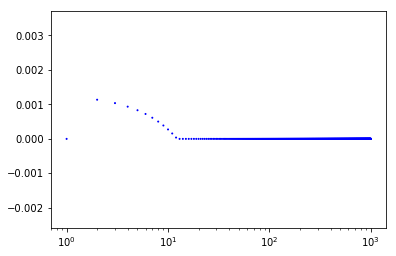

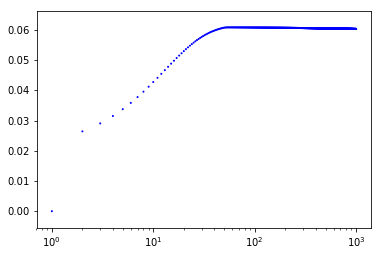

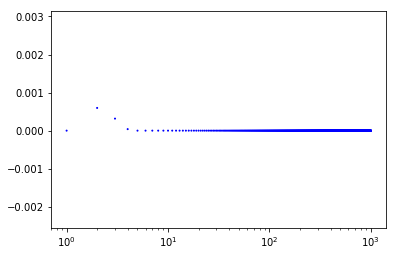

In [25]:
itr = [i for i in range(1,1002)]
s = [1 for i in range(1001)]
for i in range(13):
    ax = plt.gca()
    ax.scatter(itr,ista.wis[:,i],s=s, color='blue')
    ax.set_xscale('log')
    plt.show()

### Other tests

In [26]:
# here we run our ISTA
lambs = [0.01,0.1,0,1,10,100]
fss = []
for lamb in lambs:
    ista = ISTA(lamda = lamb)
    weights,function_value = ista.fit(X,y)
    fss.append(function_value)

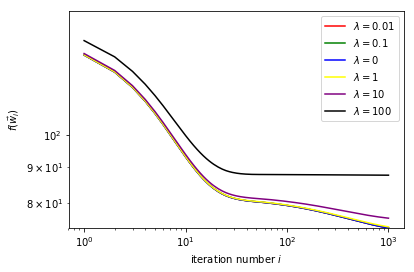

In [27]:
cols = ['red','green','blue','yellow','purple','black']
for i in range(len(lambs)):
    lab = r'$\lambda = $' + str(lambs[i])
    plt.loglog(fss[i], color=cols[i], label=lab)
plt.legend()
plt.xlabel('iteration number ' + r'$i$')
plt.ylabel(r'$f(\vec w_i)$')
plt.ylim((0,150))
plt.show()

# ISTA VS RC

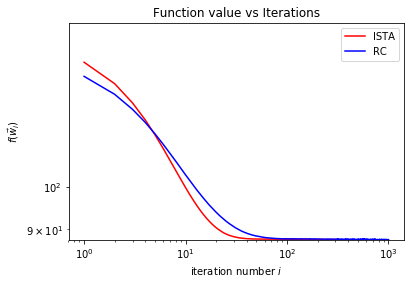

In [28]:
iterations = np.arange(len(function_value))
plt.loglog(function_value, color='red', label = 'ISTA')
plt.loglog(fs, color='blue', label = 'RC')
plt.xlabel('iteration number ' + r'$i$')
plt.ylabel(r'$f(\vec w_i)$')
plt.ylim((0,150))
plt.title('Function value vs Iterations')
plt.legend()
plt.show()

[678.33669349039462, 586.37843362687761, 586.37843362687761, 583.34902106274421, 583.34902106274421, 575.64362454366608, 575.64362454366608, 570.13441735075719, 570.13441735075719, 570.13441735075719, 570.13441735075719, 570.13441735075719, 570.13441735075719, 570.13441735075719, 570.13441735075719, 567.46665569652589, 567.46665569652589, 567.46665569652589, 567.46665569652589, 567.46665569652589, 567.46665569652589, 567.46665569652589, 567.46665569652589, 563.25336890528149, 563.25336890528149, 560.45735342570208, 560.45735342570208, 560.45735342570208, 560.45735342570208, 560.45735342570208, 560.45735342570208, 560.45735342570208, 560.45735342570208, 557.64510514289918, 557.64510514289918, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968, 555.91489515283968,

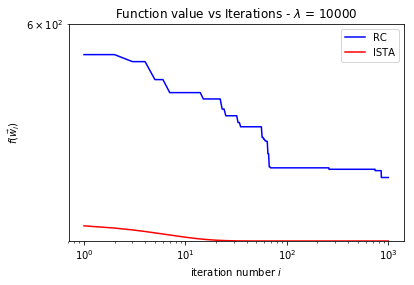

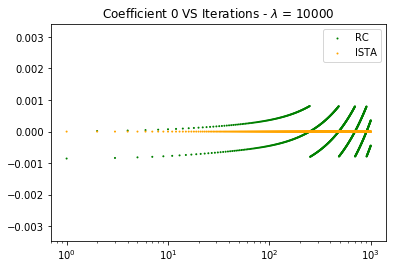

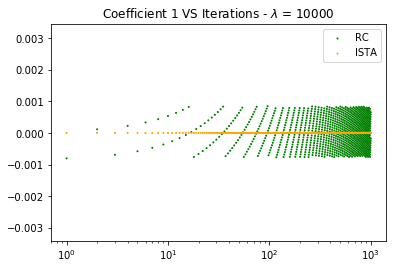

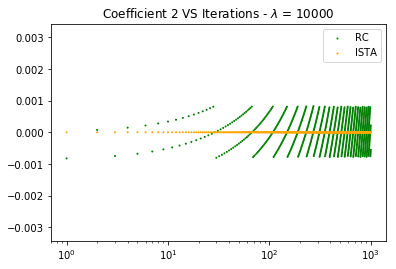

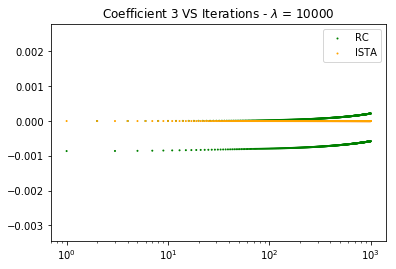

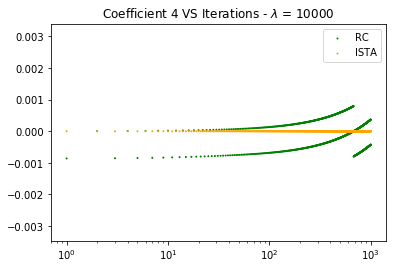

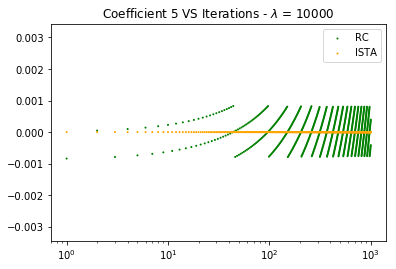

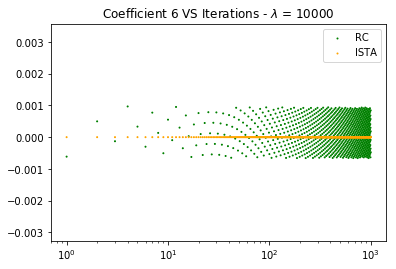

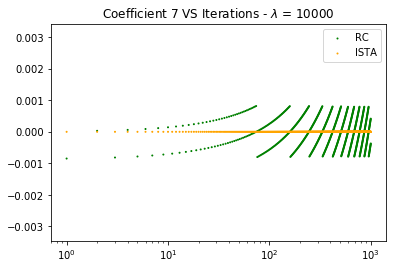

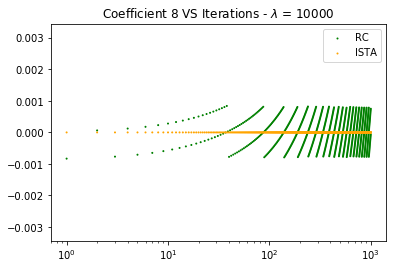

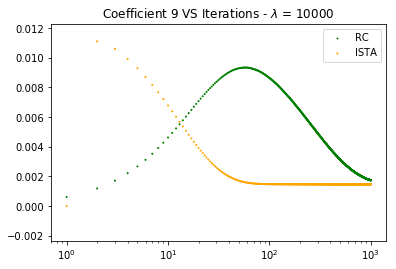

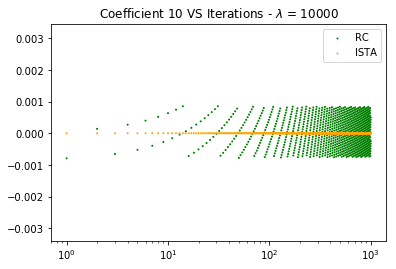

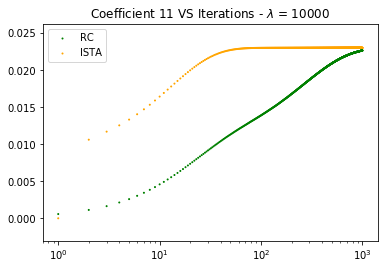

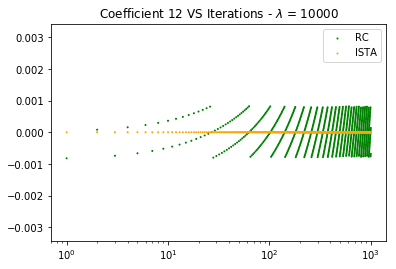

In [56]:
boston = load_boston()
lambs = [10000]
for lamb in lambs:
    X = boston.data
    y = boston.target
    y = y.reshape((y.shape[0],1))
    # solve RC
    alpha,beta,gamma = compute_bound_params(X,y,lamb)
    n_iter = 1000
    t = 6500
    fs, wis = mirror_descent(lamb,n_iter,t)
    wis = np.array(wis)
    # solve ISTA
    y = boston.target
    ista = ISTA(lamda = lamb)
    weights,function_value = ista.fit(X,y)
    # plot comparison
    print(fs)
    print()
    print(function_value)
    iterations = np.arange(len(function_value))
    plt.loglog(fs, color='blue', label = 'RC')
    plt.loglog(function_value, color='red', label = 'ISTA')
    plt.xlabel('iteration number ' + r'$i$')
    plt.ylabel(r'$f(\vec w_i)$')
    plt.ylim((0,600))
    plt.title('Function value vs Iterations - ' + r'$\lambda$' + ' = ' + str(lamb))
    plt.legend()
    plt.show()
    # other plot comparison
    itr = [i for i in range(1,1002)]
    s = [1 for i in range(1001)]
    for i in range(13):
        plt.title('Coefficient ' + str(i) + ' VS Iterations - ' + r'$\lambda$' + ' = ' + str(lamb))
        ax = plt.gca()
        ax.scatter(itr[:-1],wis[:,i],s=s, color='green', label = 'RC')
        ax.scatter(itr,ista.wis[:,i],s=s, color='orange', label = 'ISTA')
        ax.set_xscale('log')
        plt.legend()
        plt.show()